# DYNASTY - SHRED: Forecasting on a single transient

This notebook implements the SHRED architecture to the RELAP5 of the DYNASTY facility, considering the case in which only both model and exp data are available.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Let us import the data

In [7]:
path_snaps = '../../NuSHRED_Datasets/D3/prediction_dataset.npz'

data = np.load(path_snaps, allow_pickle=True)

# Load the data
dataset = data['snaps'].item()
simulation_time = data['simulation_time']

var_names = list(dataset.keys())

Nt = len(simulation_time)
ntrajectories = 1

assert ntrajectories == dataset[var_names[0]].shape[0]
assert Nt == dataset[var_names[0]].shape[1]
Nh = dataset[var_names[0]].shape[2]

print('Number of snapshots:      ', ntrajectories)
print('Number of time steps:     ', Nt)
print('Number of spatial points: ', Nh)

Number of snapshots:       1
Number of time steps:      2000
Number of spatial points:  122


Let us split the dataset into train, test, valid.

In [8]:
train_cut = 0.75
valid_cut = 0.9
split_idx = {
    'train': np.arange(0, int(Nt*train_cut), 1),
    'valid': np.arange(int(Nt*train_cut), int(Nt*valid_cut), 1),
    'test': np.arange(int(Nt*valid_cut), Nt, 1)
}

## Singular Value Decomposition
The Singular Value Decomposition (SVD) is used to compress the data and to extract the most important features.

In [12]:
from scalers import MyScaler
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import MinMaxScaler

rescaling_snaps = list()
u_total = dict()
s_total = dict()
Nmodes = list()

modes_number = [10] * len(var_names)

for field_i, field in enumerate(var_names):
    u = dataset[field].reshape(-1, Nh).T
    
    rescaling_snaps.append(MinMaxScaler())
    rescaling_snaps[field_i].fit(u.T)
    
    X = rescaling_snaps[field_i].transform(u.T).T

    assert X.shape[0] == Nh
    assert X.shape[1] == Nt
    
    _Nmodes = modes_number[field_i]
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, _ = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
Nmodes = np.asarray(Nmodes)

Let us plot the sing vals

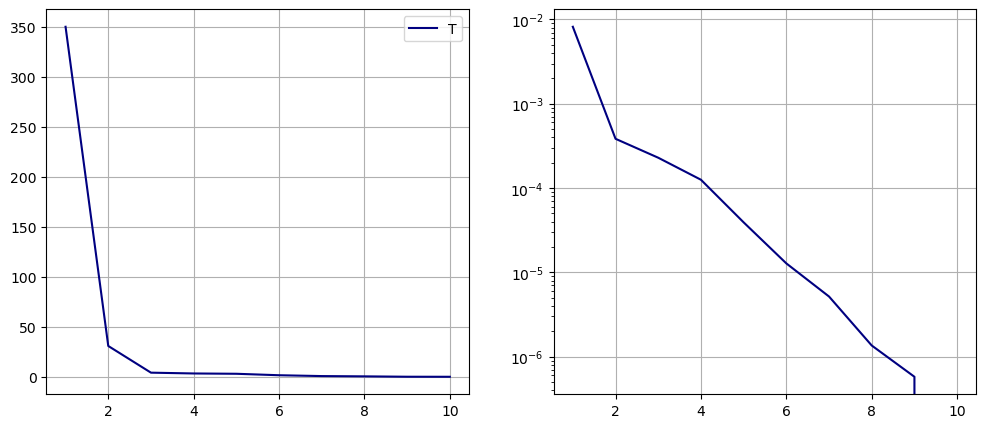

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].plot(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

Let us compute the training SVD errors

In [14]:
for field_i in range(len(var_names)):
    field = var_names[field_i]
    true_field = rescaling_snaps[field_i].transform(dataset[field].reshape(-1, Nh)).T

    _coeff_POD = np.linalg.multi_dot([
        np.linalg.inv(np.diag(s_total[field])), u_total[field].T, true_field
    ]).T
    rec = np.linalg.multi_dot([u_total[field], np.diag(s_total[field]), _coeff_POD.T])
    errors = np.linalg.norm(rescaling_snaps[field_i].inverse_transform(rec.T) - rescaling_snaps[field_i].inverse_transform(true_field.T), axis = 1) / np.linalg.norm(rescaling_snaps[field_i].inverse_transform(true_field.T), axis=1)

    print(field)
    print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

T
   max = 2.832e-02 and ave 7.061e-04


Let us store the POD coefficients

In [18]:
_v_POD = dict()

for field in var_names:
    _v_POD[field] = np.linalg.multi_dot([np.linalg.inv(np.diag(s_total[field])),  u_total[field].T, rescaling_snaps[field_i].transform(dataset[field].reshape(-1,Nh)).T])

Let us reshape the coefficients

In [19]:
v_POD = np.concatenate([_v_POD[var_names[field_i]].T.reshape(1, Nt, Nmodes[field_i]) 
                                for field_i in range(len(var_names))], axis=-1)

print(v_POD.shape)

(1, 2000, 10)


## Compute Measures
The SHRED architecture requires as input 3 measures from sensors: in this notebook the measures are the $(x,y)$ coordinates of the cells over time and one of the fluid thermocouples.

In [33]:
tc_exp_idx = np.array([1, 25, 55, 92]) - 1

measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 1
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = list()

for kk in tqdm(range(n_configurations), 'Creating sensors'):

    np.random.seed(1)
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(tc_exp_idx, size=num_sensors, replace=False), dtype=int)

    snap_measurements.append(dataset[var_names[measured_field]][0, :, idx_sensor_locations[:,kk]].T.reshape(1, -1, num_sensors))

Creating sensors: 100%|██████████| 1/1 [00:00<00:00, 3279.36it/s]


Let us plot the different configurations of sensors

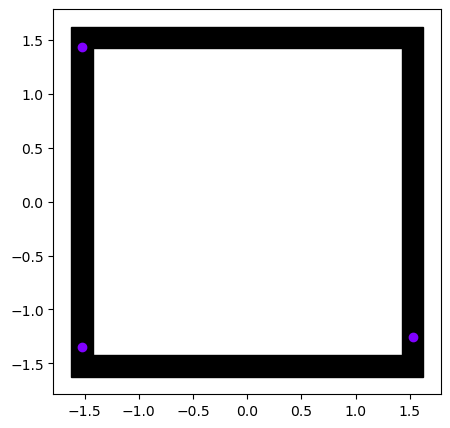

In [ ]:
from plots import add_tubes, extract_dynasty_coordinates
import matplotlib.colors as mcolors

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5))

x_dyn, y_dyn = extract_dynasty_coordinates()

add_tubes(axs, _s = 0.1, facecolors=['black', 'white'])

cmap = cm.rainbow
colors = cmap(np.linspace(0,1,n_configurations))
for kk in range(n_configurations):
    axs.scatter(x_dyn[idx_sensor_locations[:, kk]], y_dyn[idx_sensor_locations[:, kk]], color=colors[kk])

import os
path_res = './Test_Results/ValidationForecasting/'
os.makedirs(path_res, exist_ok=True)
fig.savefig(path_res+'sensors.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us add some noise to the measures

In [35]:
noise_value = 2/100
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append( snap_measurements[kk] * (1+np.random.normal(scale=noise_value, size=snap_measurements[kk].shape)))

print('Sensors Shape')
print(Xsensor[0].shape)

Sensors Shape
(1, 2000, 3)


Let us plot some configurations

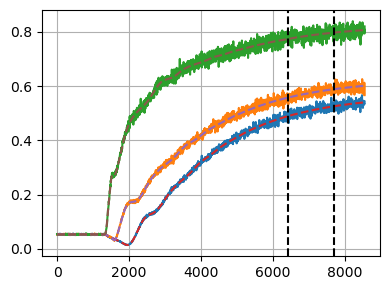

In [37]:
ncols = 1
nrows = 1
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize= (4 * ncols, 3 * nrows))
axs = np.array(axs).reshape(-1)

for kk in range(nrows * ncols):
    axs[kk].plot(simulation_time, Xsensor[kk][0], label='Noisy')
    axs[kk].plot(simulation_time, snap_measurements[kk][0], '--', label='FOM')
    axs[kk].grid()

    axs[kk].axvline(simulation_time[split_idx['train'][-1]], color='black', linestyle='--')
    axs[kk].axvline(simulation_time[split_idx['valid'][-1]], color='black', linestyle='--') 
    
plt.tight_layout()

Let us scale them to be in the range $[0, 1]$

In [38]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk].reshape(-1, num_sensors))

    rescaled_Xsensor.append(sens_scaler[kk].transform(Xsensor[kk].reshape(-1, num_sensors)).reshape(Xsensor[kk].shape))

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0].shape)

Rescaled Sensors Shape
(1, 2000, 3)


## Padding
In this section, the data are prepared to be fed into the SHRED architecture.
At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [39]:
assert sum(Nmodes) == v_POD.shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD.reshape(-1, sum(Nmodes)))

rescaled_v_POD = vpod_scaler.transform(v_POD.reshape(-1, sum(Nmodes))).reshape(v_POD.shape)

Then, let us prepare them for the SHRED architecture

In [40]:
import sys
sys.path.append('../../')

from shred.processdata import Padding, TimeSeriesDataset
import torch

## GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 30

# Input Data
data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk].reshape(1, Nt, num_sensors)), lags).to(device) for kk in range(n_configurations)]

train_data_in = [data_in[kk][split_idx['train']] for kk in range(n_configurations)]
valid_data_in = [data_in[kk][split_idx['valid']] for kk in range(n_configurations)]
test_data_in  = [data_in[kk][split_idx['test']] for kk in range(n_configurations)]

# Output Data
train_data_out = Padding(torch.from_numpy(rescaled_v_POD[:, split_idx['train']]), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.from_numpy(rescaled_v_POD[:, split_idx['valid']]), 1).squeeze(1).to(device)
test_data_out  = Padding(torch.from_numpy(rescaled_v_POD[:, split_idx['test']]), 1).squeeze(1).to(device)
output_size = sum(Nmodes)

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]

## SHRED
Let us train the SHRED models for each configuration

In [41]:
from shred.models import SHRED, fit

train_net = True

shred = list()
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))

    if train_net:
        print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 3000, lr = 1e-4, verbose = True, patience = 100)

        torch.save(shred[kk].state_dict(), path_res+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred')
        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_res+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred',
                                             map_location=device))
    

Training SHRED - configuration 1/1
Training done: Training loss = 7.80% 	 Validation loss = 1.80%       
 


### Testing SHRED
In this section, the reliability of the SHRED network are assessed.

In [42]:
from shred.processdata import num2p, mre

[_shred.freeze() for _shred in shred]

Ytest_POD_hat = torch.stack([shred[kk](test_data_in[kk]) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0)
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,
                                                                            Ytest_POD_pred['mean'])))

Mean relative SHRED prediction error on POD coeffs: 3.38%.


Let us make a plot of the latent dynamics

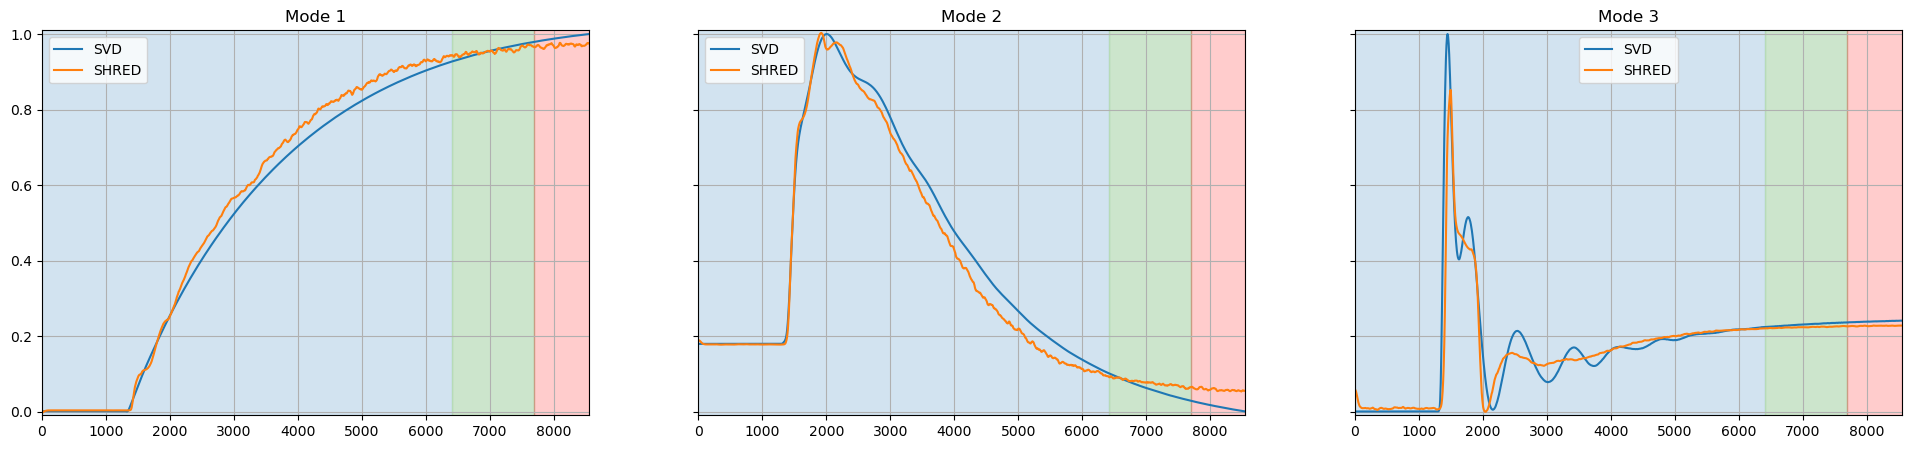

In [45]:
fig, axs = plt.subplots(nrows = len(var_names), ncols = 3, sharex=True, sharey=True, figsize=(6 * 4, 5 * len(var_names)))

axs = axs.reshape(len(var_names), 3)

for field_i, field in enumerate(var_names):
    for rr in range(3):
        axs[field_i, rr].plot(simulation_time, rescaled_v_POD[0,:,rr], label='SVD')
        axs[field_i, rr].plot(simulation_time, shred[0](data_in[0]).cpu().detach().numpy()[:,rr], label='SHRED')

        axs[field_i, rr].fill_betweenx(x1 = simulation_time[0], x2 = simulation_time[split_idx['train']][-1],y=[-1,1.5],
                                       alpha=0.2)
        axs[field_i, rr].fill_betweenx(x1 = simulation_time[split_idx['train']][-1], x2 = simulation_time[split_idx['valid']][-1],y=[-1,1.5],
                                        alpha=0.2, color='green')
        axs[field_i, rr].fill_betweenx(x1 = simulation_time[split_idx['valid']][-1], x2 = simulation_time[split_idx['test']][-1],y=[-1,1.5],
                                        alpha=0.2, color='red')

        axs[field_i, rr].grid()
        axs[field_i, rr].set_title('Mode '+str(rr+1))
        axs[field_i, rr].legend()
        axs[field_i, rr].set_ylim(-0.01, 1.01)
        axs[field_i, rr].set_xlim(0, simulation_time[-1])


Decode to high-dimensional state

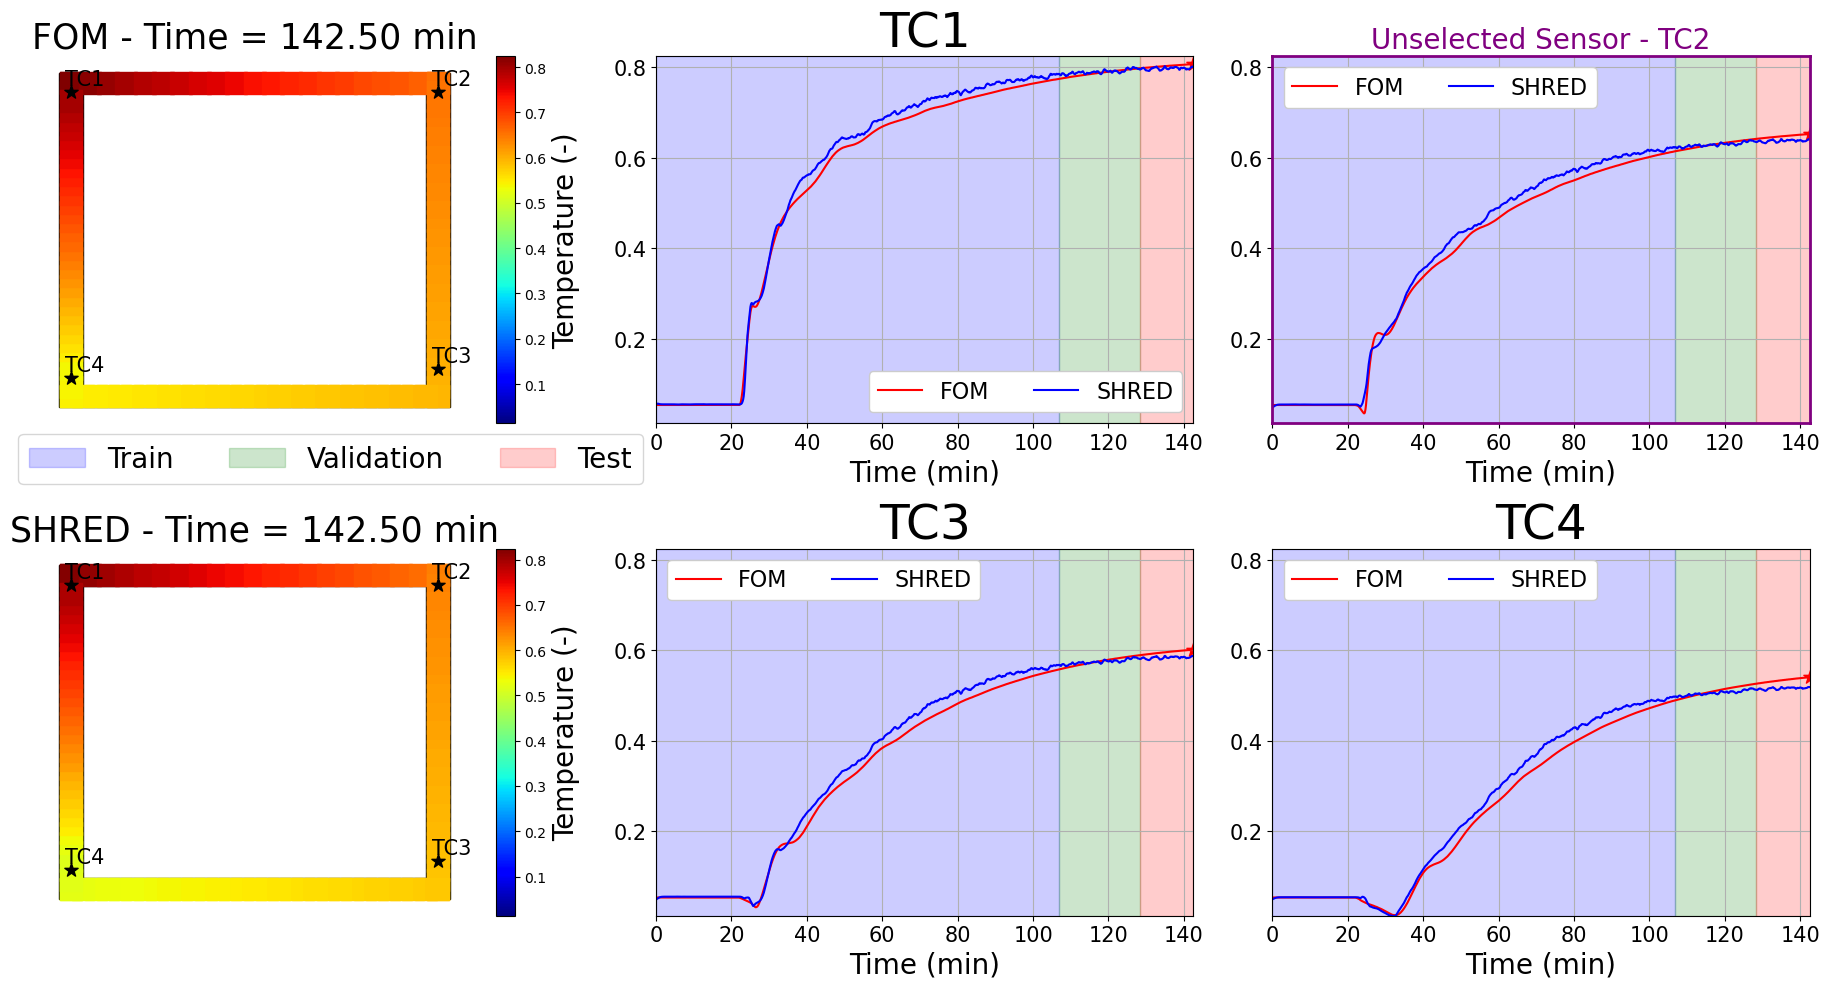

In [48]:
_tmp_mean = vpod_scaler.inverse_transform(shred[0](data_in[0]).cpu().detach().numpy()).T

recon = rescaling_snaps[field_i].inverse_transform(np.linalg.multi_dot([u_total[var_names[0]], np.diag(s_total[var_names[0]]), _tmp_mean]).T).T

from plots import plot_loop_FOM_vs_SHRED

# Define experimental index
exp_idx = np.array([1, 25, 55, 92]) - 1

_fig = plot_loop_FOM_vs_SHRED(  dataset[field][0].T, recon, simulation_time, -1, 0,
                                    exp_idx, std_shred=None, exp_data=None,
                                    lims = [dataset[field].min(), dataset[field].max()],
                                    cmap = cm.jet)



unselected_value = np.setdiff1d(exp_idx, idx_sensor_locations)[0]
unselected_position = np.where(exp_idx == unselected_value)[0][0]                                

axs = _fig.get_axes()[:-2]
axs = [axs[0], axs[3], axs[1], axs[2], axs[4], axs[5]]

# Frame the unselected sensor
unselected_value = np.setdiff1d(exp_idx, idx_sensor_locations)
for unselec_i in range(len(unselected_value)):
    unselected_position = np.where(exp_idx == unselected_value[unselec_i])[0][0]                                

    # Frame the unselected sensor
    axs[2+unselected_position].spines['top'].set_color('purple')
    axs[2+unselected_position].spines['bottom'].set_color('purple')
    axs[2+unselected_position].spines['left'].set_color('purple')
    axs[2+unselected_position].spines['right'].set_color('purple')

    axs[2+unselected_position].spines['top'].set_linewidth(2)
    axs[2+unselected_position].spines['bottom'].set_linewidth(2)
    axs[2+unselected_position].spines['left'].set_linewidth(2)
    axs[2+unselected_position].spines['right'].set_linewidth(2)
    axs[2+unselected_position].set_title('Unselected Sensor - TC'+str(unselected_position+1), 
                                        fontsize=20, color='purple')

# Create shaded areas
for ii in range(len(exp_idx)):
    axs[2+ii].fill_betweenx(x1 = simulation_time[0]/60, x2 = simulation_time[split_idx['train']][-1]/60,y=[dataset[field].min(), dataset[field].max()],
                            alpha=0.2, color='blue', label='Train')
    axs[2+ii].fill_betweenx(x1 = simulation_time[split_idx['train']][-1]/60, x2 = simulation_time[split_idx['valid']][-1]/60,y=[dataset[field].min(), dataset[field].max()],
                            alpha=0.2, color='green', label='Validation')
    axs[2+ii].fill_betweenx(x1 = simulation_time[split_idx['valid']][-1]/60, x2 = simulation_time[-1]/60,y=[dataset[field].min(), dataset[field].max()],
                            alpha=0.2, color='red', label='Test')

import matplotlib.patches as mpatches

# Create proxy patches for the legend
train_patch = mpatches.Patch(color='blue', alpha=0.2, label='Train')
valid_patch = mpatches.Patch(color='green', alpha=0.2, label='Validation')
test_patch = mpatches.Patch(color='red', alpha=0.2, label='Test')

# Add a figure-level legend
_fig.legend(handles=[train_patch, valid_patch, test_patch], loc=(0.01, 0.51), fontsize=20, ncols=3)

_fig.savefig(path_res+'FOM_vs_SHRED_verification.png', format='png', dpi=250, bbox_inches='tight')

## Testing with Exp Data
Let us observe how the SHRED models perform on this configuration, using as sensor input the real data.

In [50]:
exp_data = np.load('../../NuSHRED_Datasets/D3/exp_data.npz')
exp_data = {
    'Time': exp_data['Time'][::5],
    'TC': exp_data['TC'][:, ::5],
} # elements in the training time are selected

# This function is used to extract the configuration from the exp measures
def convert_to_order(exp_idx, idx_sensor_locations):
    idx_map = {value: idx for idx, value in enumerate(exp_idx)}
    order_matrix = np.vectorize(idx_map.get)(idx_sensor_locations)
    
    return order_matrix
order_idx_sens = convert_to_order(exp_idx, idx_sensor_locations)

Let us extract the measures consistently with the SHRED selection and let us rescale them.

In [51]:
new_Xsensor = np.zeros((n_configurations, 1, len(exp_data['Time']), num_sensors))
rescaled_Xsensor = list()

for kk in range(n_configurations):
    for jj in range(num_sensors):
        new_Xsensor[kk, 0, :, jj] = exp_data['TC'][order_idx_sens[jj, kk]]
    rescaled_Xsensor.append(sens_scaler[kk].transform(new_Xsensor[kk].reshape(-1, num_sensors)).reshape(new_Xsensor[kk].shape))

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0].shape)

Rescaled Sensors Shape
(1, 1371, 3)


Let us create the sequence using the Padding function

In [52]:
test_data_exp_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]), lags).to(device) for kk in range(n_configurations)]

Let us reconstruct the output using the SHRED models

In [55]:
test_data_exp_out = torch.stack([shred[kk](test_data_exp_in[kk]) for kk in range(n_configurations)], dim=0)

reshaped_POD_test_exp_out = {
    'mean': test_data_exp_out.mean(axis=0).cpu().detach().numpy().reshape(new_Xsensor[0].shape[0],new_Xsensor[0].shape[1], sum(Nmodes)),
}

Let us plot the results

In [63]:
from plots import plot_loop_FOM_vs_SHRED

path_fig = path_res+'FigsExp/'
os.makedirs(path_fig, exist_ok=True)

param_to_plot = -1
field = var_names[0]

fom = dataset[field][0].T
fom_upscaled = np.zeros((fom.shape[0], exp_data['Time'].shape[0]))
for ii in range(fom.shape[0]):
    fom_upscaled[ii] = np.interp(exp_data['Time'], simulation_time, fom[ii])

# Reconstruct the FOM
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_exp_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_exp_out['mean'].shape)

recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]).T).T

# for time_idx in [len(exp_data_clean['Time']) - 1]:
for time_idx in tqdm(range(0, len(exp_data['Time']), 20)):
    
    # time_idx = 1000

    filename = path_fig+'SHRED_TC_time{:.2f}.png'.format(exp_data['Time'][time_idx])

    _fig = plot_loop_FOM_vs_SHRED(  fom_upscaled, recon, exp_data['Time'], time_idx, 0,
                                    exp_idx, std_shred=None, exp_data=exp_data,
                                    lims = [exp_data['TC'].min(), exp_data['TC'].max()],
                                    cmap = cm.jet, sampling_exp=5)

    unselected_value = np.setdiff1d(exp_idx, idx_sensor_locations)[0]
    unselected_position = np.where(exp_idx == unselected_value)[0][0]                                

    axs = _fig.get_axes()[:-2]
    axs = [axs[0], axs[3], axs[1], axs[2], axs[4], axs[5]]

    # Frame the unselected sensor
    unselected_value = np.setdiff1d(exp_idx, idx_sensor_locations)
    for unselec_i in range(len(unselected_value)):
        unselected_position = np.where(exp_idx == unselected_value[unselec_i])[0][0]                                

        # Frame the unselected sensor
        axs[2+unselected_position].spines['top'].set_color('purple')
        axs[2+unselected_position].spines['bottom'].set_color('purple')
        axs[2+unselected_position].spines['left'].set_color('purple')
        axs[2+unselected_position].spines['right'].set_color('purple')

        axs[2+unselected_position].spines['top'].set_linewidth(2)
        axs[2+unselected_position].spines['bottom'].set_linewidth(2)
        axs[2+unselected_position].spines['left'].set_linewidth(2)
        axs[2+unselected_position].spines['right'].set_linewidth(2)
        axs[2+unselected_position].set_title('Unselected Sensor - TC'+str(unselected_position+1), 
                                            fontsize=20, color='purple')

    # Create shaded areas
    for ii in range(len(exp_idx)):
        axs[2+ii].fill_betweenx(x1 = simulation_time[0]/60, x2 = simulation_time[split_idx['train']][-1]/60,y=[dataset[field].min(), dataset[field].max()],
                                alpha=0.2, color='blue', label='Train')
        axs[2+ii].fill_betweenx(x1 = simulation_time[split_idx['train']][-1]/60, x2 = simulation_time[split_idx['valid']][-1]/60,y=[dataset[field].min(), dataset[field].max()],
                                alpha=0.2, color='green', label='Validation')
        axs[2+ii].fill_betweenx(x1 = simulation_time[split_idx['valid']][-1]/60, x2 = exp_data['Time'][-1]/60,y=[dataset[field].min(), dataset[field].max()],
                                alpha=0.2, color='red', label='Test')

    import matplotlib.patches as mpatches

    # Create proxy patches for the legend
    train_patch = mpatches.Patch(color='blue', alpha=0.2, label='Train')
    valid_patch = mpatches.Patch(color='green', alpha=0.2, label='Validation')
    test_patch = mpatches.Patch(color='red', alpha=0.2, label='Test')

    # Add a figure-level legend
    _fig.legend(handles=[train_patch, valid_patch, test_patch], loc=(0.01, 0.51), fontsize=20, ncols=3)

    _fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')
    plt.close(_fig)                     

100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Let us create the gif

In [64]:
from plots import make_gif

make_gif(path_fig, path_res+'SHRED_validation_forecasting_TC.gif', duration = 50)